## Hydrograph Development Notebook

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
from scipy.integrate import trapz, cumtrapz, simps

from importlib import reload
import utils; reload(utils)
from utils import *

%matplotlib inline

## Selection of Initial Hydrograph 
- For unsteady flow analysis, the shape of the hydrograph and resulting volume of flow is of primary importance for modeling flood inundation extent. In order to develop a hydrograph with the appropriate shape, we will use the plots from FirstLook as a starting point.
- The Hydrograph will then be stretched to the 100 yr Peak flow value, derived from the USGS PeakFQ software, using Bulletin 17-B methodology to analyze the peaks of record.

### Gage Data
- The gage (01509520, Lisle, NY) located nearest our area of interest was installed in June of 2017, provideing limited data. Therefore we will need to look upstream to find another gage, and evaluate the Drainage Area and make some assumptions in order to approximate the downstream flows.


- The neares gage (01509520, Cortland, NY) with sufficent data is located upstream, with a difference in drainage area of ~161 sqaure miles.

**Read in USGS Gage Records**

01509000_00060_dv.tsv
01509000_00060_iv.tsv
01509000_00065_iv.tsv
01509520_00065_iv.tsv
01511500_00065_iv.tsv


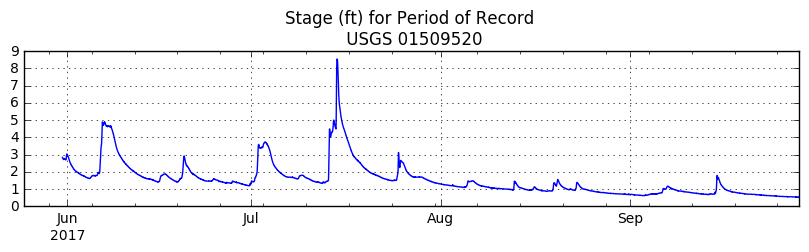

In [4]:
import ny_clean_nb; reload(ny_clean_nb)
from ny_clean_nb import *
df = initialize()



# Analyis:
### Assess appropriateness of using upstream gage to develop downstream hydrograph
From FirstLook, we know that the the peak of record for the upstream gage, Cortland occurred on 2005-04-03. For this gage we have daily and instaneous values.


**Interpolated daily flows result in a lower peak flow, but a greater total volume of water:**

Maximum Daily Flow = 12644.0 cfs
Maximum Inst Flow = 14211.0 cfs
Volume from Instantaneous Observations = 	3768994817
Volume from Daily Mean Observations = 		3961011255

Using Daily means yields = 192016438 more Cubic Feet of Water
(Daily means results in a difference of volume of ~ 5.0946326020616% )


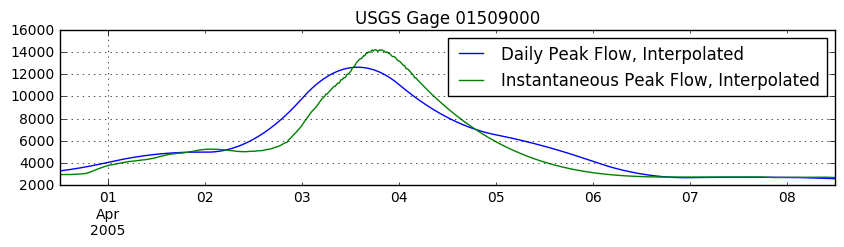

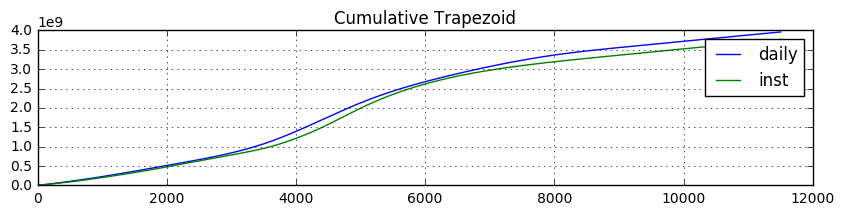

In [5]:
import ny_clean_nb; reload(ny_clean_nb)
from ny_clean_nb import *
Daily_vs_Instant(df)

### Stretch hydrograph of mean daily averages to the peak flow from the instanteous records
Assess achange in shape & volume of hydrograph


**Results from Stretched Daily flows compared with Instantaneous Records**

Maximum Daily Flow (stretched) = 14233.0 cfs
Maximum Inst Flow = 14211.0 cfs
Volume from Instantaneous Observations = 	3768994817
Volume from Stretched Daily Mean Observations = 		4099493019

Using Stretched Daily means yields = 330498202 more Cubic Feet of Water
(Streteched Daily means results in a difference of volume of ~ 8.768868584889358% )


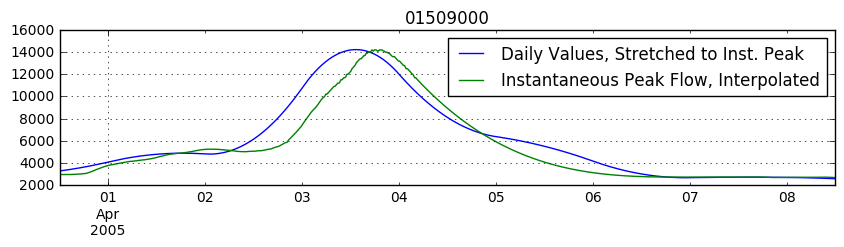

In [7]:
import ny_clean_nb; reload(ny_clean_nb)
from ny_clean_nb import *
Stretched_Daily_vs_Instant(df, plot_cumulative = False)

# Stretch the Hydrograph to the 100 yr flow
* 100 yr flow obtained for this gage using USGS PeakFQ Bulletin 17-B analysis

**Hydrograph properties:**

Maximum Daily Flow (stretched) = 20976.0 cfs
Maximum Inst Flow = 14211.0 cfs
Volume from Instantaneous Observations = 	3185407414
Volume from Stretched Daily Mean Observations = 		4095163343

Using Stretched Daily means yields = 909755928 more Cubic Feet of Water
(Streteched Daily means results in a difference of volume of ~ 28.560112098366496% )


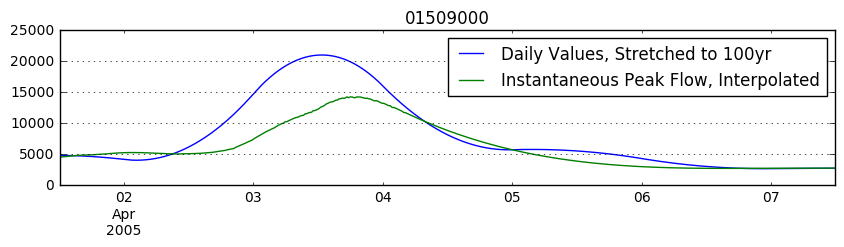

In [11]:
import ny_clean_nb; reload(ny_clean_nb)
from ny_clean_nb import *
Stretched_Daily_100yr(df)

# Let's Take a look at another event to compare shape of hydrograph

**Hydrograph properties:**

Maximum Daily Flow (stretched) = 20960.0 cfs
Maximum Inst Flow = 11503.0 cfs
Volume from Instantaneous Observations = 	2620991012
Volume from Stretched Daily Mean Observations = 		3435913252

Using Stretched Daily means yields = 814922239 more Cubic Feet of Water
(Streteched Daily means results in a difference of volume of ~ 31.09214171945464% )


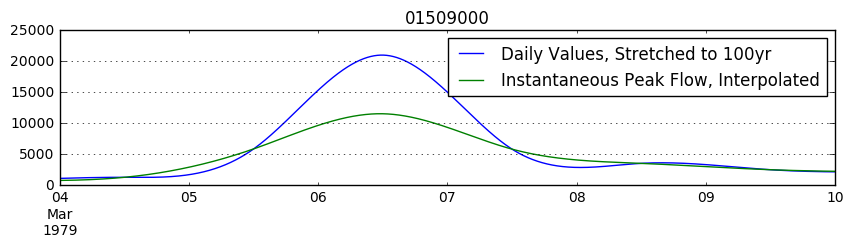

In [9]:
import ny_clean_nb; reload(ny_clean_nb)
from ny_clean_nb import *
Stretched_Daily_100yr_2(df)